# News Title Classification

#### Here we have dataset of news title that has been classed as Technology, Business, Entertainment, and Medical. Our task is to predict and classify which class does the title belong 

In [1]:
import pandas as pd
import numpy as np
import pandas.api.types as ptypes
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline

### Load the data

In [2]:
df = pd.read_excel('news_title.xls', index_col=0, as_index=False)  
df_tmp = df.copy()

In [3]:
df_tmp.head()

,News Title,Category
No,,
1,Google+ rolls out 'Stories' for tricked out ph...,Technology
2,Dov Charney's Redeeming Quality,Business
3,White God adds Un Certain Regard to the Palm Dog,Entertainment
4,"Google shows off Androids for wearables, cars,...",Technology
5,China May new bank loans at 870.8 bln yuan,Business


In [4]:
df_tmp.rename(columns = {'News Title' : 'news_title', 'Category' : 'category'}, inplace = True)

### Feature Engineering

#### We will convert all of the comments to only contain alphabet

In [5]:
def process_comment(comment):
    return " ".join(re.findall("[A-Za-z]+",comment.lower()))

In [6]:
df_tmp['proc_title'] = df_tmp['news_title'].apply(process_comment)
df_tmp['proc_title'] = df_tmp['proc_title'].astype(str)

In [7]:
df_tmp.drop('news_title', axis=1, inplace=True)

In [8]:
df_tmp

,category,proc_title
No,,
1,Technology,google rolls out stories for tricked out photo...
2,Business,dov charney s redeeming quality
3,Entertainment,white god adds un certain regard to the palm dog
4,Technology,google shows off androids for wearables cars tvs
5,Business,china may new bank loans at bln yuan
...,...,...
65531,Technology,xbox one homebrew will likely be a reality in ...
65532,Technology,maker recalls million rear facing infant seats
65533,Entertainment,watch first ninja turtles trailer


In [9]:
df_tmp.isna().sum()

category      0
proc_title    0
dtype: int64

#### Encoding Category

In [10]:
df_enc = df_tmp.copy()

In [11]:
label_encoder = preprocessing.LabelEncoder()

df_enc['category']= label_encoder.fit_transform(df_enc['category']) 
df_enc.head()

,category,proc_title
No,,
1,3,google rolls out stories for tricked out photo...
2,0,dov charney s redeeming quality
3,1,white god adds un certain regard to the palm dog
4,3,google shows off androids for wearables cars tvs
5,0,china may new bank loans at bln yuan


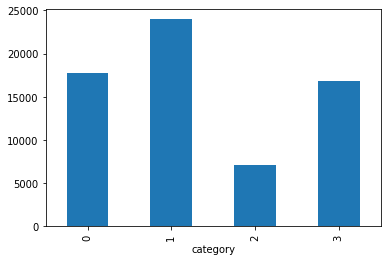

In [12]:
df_enc.groupby('category').proc_title.count().plot.bar(ylim=0)
plt.show()

We have an imbalanced dataset. However, in this case the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

#### Splitting Train and Test

In [13]:
X, y = df_enc['proc_title'], df_tmp['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Count Vectorizer and TF-IDF

Using countvectorizer to creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is nothing but the count of the word in that particular text sample.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

We will go straight to modelling as the CountVectorizer and TfidfTransformer is in the pipeline

## Modelling

### Random Forest Classifier

In [67]:
pipeline_rfc = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier()),
 ])
pipeline_rfc = pipeline_rfc.fit(X_train, y_train)

predicted_rfc = pipeline_rfc.predict(X_test)
print("Train Accuracy:",pipeline_rfc.score(X_train, y_train))
print("Test Accuracy:",pipeline_rfc.score(X_test, y_test))

Train Accuracy: 0.9988364995803769
Test Accuracy: 0.8639658197909514


As you can see from above, the accuracy scores between train and test are not close enough. This suggest that Random Forest Classifier is overfitting this data

In [68]:
print(classification_report(y_test,predicted_rfc))

               precision    recall  f1-score   support

     Business       0.85      0.83      0.84      3607
Entertainment       0.85      0.96      0.90      4802
      Medical       0.91      0.73      0.81      1428
   Technology       0.89      0.82      0.85      3270

     accuracy                           0.86     13107
    macro avg       0.87      0.83      0.85     13107
 weighted avg       0.87      0.86      0.86     13107



#### The accuracy from Random Forest Classifier is 86.4%

### Decision Tree

In [69]:
pipeline_dtc = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DecisionTreeClassifier()),
 ])
pipeline_dtc = pipeline_dtc.fit(X_train, y_train)

predicted_dtc = pipeline_dtc.predict(X_test)
print("Train Accuracy:",pipeline_dtc.score(X_train, y_train))
print("Test Accuracy:",pipeline_dtc.score(X_test, y_test))

Train Accuracy: 0.9988364995803769
Test Accuracy: 0.8158999008163577


As you can see from above, the accuracy scores between train and test are not close enough. This suggest that Decision Tree is overfitting this data

In [70]:
print(classification_report(y_test,predicted_dtc))

               precision    recall  f1-score   support

     Business       0.79      0.78      0.78      3607
Entertainment       0.84      0.89      0.86      4802
      Medical       0.76      0.71      0.74      1428
   Technology       0.83      0.80      0.81      3270

     accuracy                           0.82     13107
    macro avg       0.81      0.79      0.80     13107
 weighted avg       0.81      0.82      0.82     13107



#### The accuracy from Decision Tree is 81.6%

### Naive Bayes Classifier

In [23]:
pipeline_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
 ])
pipeline_nb = pipeline_nb.fit(X_train, y_train)

predicted_nb = pipeline_nb.predict(X_test)
print("Train Accuracy:",pipeline_nb.score(X_train, y_train))
print("Test Accuracy:",pipeline_nb.score(X_test, y_test))

Train Accuracy: 0.9242198825055314
Test Accuracy: 0.8985275043869688


As you can see from above, the accuracy scores between train and test are close enough. This suggest that Naive Bayes is not overfitting this data

In [27]:
print(classification_report(y_test,predicted_nb))

               precision    recall  f1-score   support

     Business       0.88      0.88      0.88      3607
Entertainment       0.91      0.97      0.94      4802
      Medical       0.98      0.72      0.83      1428
   Technology       0.87      0.89      0.88      3270

     accuracy                           0.90     13107
    macro avg       0.91      0.86      0.88     13107
 weighted avg       0.90      0.90      0.90     13107



#### The accuracy from Naive Bayes is 89.85%

### K-Nearest Neighbors

In [96]:
pipeline_knn = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
 ])
pipeline_knn = pipeline_knn.fit(X_train, y_train)

predicted_knn = pipeline_knn.predict(X_test)
print("Train Accuracy:",pipeline_knn.score(X_train, y_train))
print("Test Accuracy:",pipeline_knn.score(X_test, y_test))

Train Accuracy: 0.9448004882887007
Test Accuracy: 0.9099717708094911


As you can see from above, the scores are very close which indicates that we avoided over-fitting.

In [97]:
print(classification_report(y_test,predicted_knn))

               precision    recall  f1-score   support

     Business       0.88      0.89      0.89      3607
Entertainment       0.93      0.97      0.95      4802
      Medical       0.93      0.83      0.88      1428
   Technology       0.90      0.88      0.89      3270

     accuracy                           0.91     13107
    macro avg       0.91      0.89      0.90     13107
 weighted avg       0.91      0.91      0.91     13107



#### The accuracy from K-Nearest Neighbors is 91%

### SVM

In [65]:
pipeline_svm = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)),
                         ])
pipeline_svm = pipeline_svm.fit(X_train, y_train)
predicted_svm = pipeline_svm.predict(X_test)
print("Train Accuracy:",pipeline_svm.score(X_train, y_train))
print("Test Accuracy:",pipeline_svm.score(X_test, y_test))

Train Accuracy: 0.8423933775844968
Test Accuracy: 0.8318455786984055


As you can see from above, the scores are very close which indicates that we avoided over-fitting.

In [66]:
print(classification_report(y_test,predicted_svm))

               precision    recall  f1-score   support

     Business       0.87      0.80      0.83      3607
Entertainment       0.77      0.98      0.86      4802
      Medical       0.94      0.58      0.72      1428
   Technology       0.89      0.76      0.82      3270

     accuracy                           0.83     13107
    macro avg       0.87      0.78      0.81     13107
 weighted avg       0.85      0.83      0.83     13107



#### The accuracy from SVM is 83.1%

### Using GridSearchCV we want to find the optimal parameters for KNearest-Neighbors

In [80]:
parameters = {'vect__ngram_range': [(1, 1),(1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__leaf_size': (list(range(20,40,2))),
               'clf__n_neighbors': (list(range(1,10,1))),
               'clf__p': (list(range(1,5,1)))
            }

In [90]:
rs_knn = RandomizedSearchCV(pipeline_knn, param_distributions=parameters, verbose=8, cv=5)
rs_knn = rs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28, score=0.835, total=  10.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28, score=0.828, total=  10.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s


[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28, score=0.831, total=  10.7s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.8s remaining:    0.0s


[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28, score=0.834, total=  10.9s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   42.7s remaining:    0.0s


[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=2, clf__leaf_size=28, score=0.833, total=  11.1s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.8s remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28, score=0.856, total=  12.2s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28, score=0.856, total=  12.2s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28, score=0.860, total=  12.2s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28, score=0.861, total=  11.6s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=2, clf__n_neighbors=9, clf__leaf_size=28, score=0.860, total=  11.4s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22, score=nan, total=   1.7s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=False, clf__p=4, clf__n_neighbors=3, clf__leaf_size=22, score=nan, total=   1.7s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32, score=nan, total=   0.6s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32, score=nan, total=   0.6s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32, score=nan, total=   0.6s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32, score=nan, total=   0.6s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=3, clf__n_neighbors=6, clf__leaf_size=32, score=nan, total=   0.6s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22, score=0.837, total=  15.8s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22, score=0.832, total=  16.1s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22, score=0.830, total=  15.2s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22, score=0.833, total=  16.5s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=4, clf__leaf_size=22 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=True, clf__p=1, clf__n_neighbors=

C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34, score=nan, total=   2.0s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34, score=nan, total=   1.7s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34, score=nan, total=   1.7s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=8, clf__leaf_size=34, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neighbors=5, clf__leaf_size=32 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neighbors=5, clf__leaf_size=32, score=0.814, total=  15.9s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neighbors=5, clf__leaf_size=32 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neighbors=5, clf__leaf_size=32, score=0.808, total=  17.0s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neighbors=5, clf__leaf_size=32 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neighbors=5, clf__leaf_size=32, score=0.815, total=  17.1s
[CV] vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neighbors=5, clf__leaf_size=32 
[CV]  vect__ngram_range=(1, 1), tfidf__use_idf=False, clf__p=1, clf__n_neig

C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=3, clf__n_neighbors=1, clf__leaf_size=26, score=nan, total=   1.6s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30, score=nan, total=   1.7s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30, score=nan, total=   1.7s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30, score=nan, total=   1.7s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30, score=nan, total=   1.9s
[CV] vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30 


C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\audia\AppData\Roaming\Python\Python38\site-packages\sklearn\neighbors\_base.py", line 419, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse i

[CV]  vect__ngram_range=(1, 2), tfidf__use_idf=True, clf__p=4, clf__n_neighbors=2, clf__leaf_size=30, score=nan, total=   1.8s


In [92]:
rs_knn.best_params_

{'vect__ngram_range': (1, 1),
 'tfidf__use_idf': True,
 'clf__p': 2,
 'clf__n_neighbors': 7,
 'clf__leaf_size': 30}

In [93]:
predicted = rs_knn.predict(X_test)
np.mean(predicted == y_test)

0.9127946898603799

In [95]:
print(classification_report(y_test,predicted))

               precision    recall  f1-score   support

     Business       0.89      0.89      0.89      3607
Entertainment       0.94      0.97      0.95      4802
      Medical       0.94      0.83      0.88      1428
   Technology       0.90      0.89      0.89      3270

     accuracy                           0.91     13107
    macro avg       0.91      0.90      0.90     13107
 weighted avg       0.91      0.91      0.91     13107



### We have increased accuracy from 91% to 91.3%

### The result are great for predicting spam comments!

#### Notes: The f1-score on 4 categories of news is pretty good despite the fact that the data is imbalanced. We use f1-score as evaluation metric because the data is imbalanced and it is a multiclass problem, which ROC-AUC curve is harder to interpret.

## NLTK (Natural Language Toolkit)

stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form. E.g. A stemming algorithm reduces the words “fishing”, “fished”, and “fisher” to the root word, “fish”.
We need NLTK to do this. NLTK comes with various stemmers which can help reducing the words to their root form.

In [98]:
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer()
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                          ('tfidf', TfidfTransformer()),
                          ('mnb', MultinomialNB(fit_prior=False)),
                             ])
text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)
predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)
np.mean(predicted_mnb_stemmed == y_test)

0.9065384908827344

#### NLTK and stemming does not increase our previous accuracy

###### By Audi Armadhani for Bagidata